## Imports

In [12]:
import json
import sys
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from numpy.random import normal
from os import listdir
from time import sleep
sys.path.append('../../stationsim/')

%matplotlib inline

from stationsim_model import Model
from ensemble_kalman_filter import EnsembleKalmanFilter

## Functions

In [3]:
# Utility functions
def make_truth_data(model_params):
    """
    Run StationSim to generate synthetic truth data.
    Returns a list of the states of each agent;
    Each list entry is the state of the agents at a timestep.
    """
    # Run model with provided params
    model = Model(model_params)
    model.batch()

    # Extract agent tracks
    return model.state_history

def make_observation_data(truth, noise_mean=0, noise_std=1):
    """
    Add noise to truth data to generate noisy observations.
    Noise is drawn from a Normal distribution.
    We assume that sensors are unbiased, and so by default mean=0.
    """
    observations = list()
    for timestep in truth:
        ob = timestep + normal(noise_mean, noise_std, timestep.shape)
        observations.append(ob)
    return observations

def make_dataframe(dataset, times):
    """
    make_dataframe

    Make a dataframe from a dataset.
    This requires that the data undergo the following transformations:
        - Convert to numpy array
        - Transpose array
        - Convert array to pandas dataframe
        - Calculate row-mean in new column
        - Add time to data
        - Set time as index

    Parameters
    ----------
    dataset : list(list())
        List of lists containing data.
        Each inner list contains a single time-series.
        The outer list contains a collection of inner lists, each pertaining to
        a realisation of the model.
    times : list-like
        List of times at which data is provided.
    """
    d = pd.DataFrame(np.array(dataset).T)
    m = d.mean(axis=1)
    s = d.std(axis=1)
    up = d.max(axis=1)
    down = d.min(axis=1)
    d['mean'] = m
    d['up_diff'] = up - m
    d['down_diff'] = m - down
    d['sd'] = s
    d['time'] = times
    return d.set_index('time')
        
def extract_array(df, var1, var2):
    """
    Function to extract data array pertaining to the variables that we are
    interested in.

    Extract an array of the mean errors with two parameters varying; other
    parameters are kept fixed.
    First define the default values for each of the four possible parameters
    (assimilation period, ensemble size, population size and observation noise
    standard deviation).
    Get the sorted values that each of the chosen parameters take.
    Create an array of the data that fits the above conditions, and convert
    into an array with column indices taking the values of the first parameter
    and the row indices taking the value of the second parameter.

    Parameters
    ----------
    df : pandas dataframe
        A pandas dataframe containing all of the mean errors for each of the
        parameter combinations.
    var1 : string
        Name of the first variable that we want to consider variation with
        respect to.
    var2 : string
        Name of the second variable that we want to consider variation with
        respect to.
    """
    # Define variables to fix and filter
    fixed_values = {'assimilation_period': 20,
                    'ensemble_size': 20,
                    'population_size': 15,
                    'std': 1.5}

    var1_vals = sorted(df[var1].unique())
    var2_vals = sorted(df[var2].unique())
    fix_vars = [x for x in fixed_values.keys() if x not in [var1, var2]]
    print(var1, var1_vals)
    print(var2, var2_vals)

    # Filtering down to specific fixed values
    cond1 = df[fix_vars[0]] == fixed_values[fix_vars[0]]
    cond2 = df[fix_vars[1]] == fixed_values[fix_vars[1]]
    tdf = df[cond1 & cond2]

    # Reformat to array
    a = np.zeros(shape=(len(var1_vals), len(var2_vals)))
    for i, u in enumerate(var1_vals):
        for j, v in enumerate(var2_vals):
            var1_cond = tdf[var1]==u
            var2_cond = tdf[var2]==v
            d = tdf[var1_cond & var2_cond]
            a[i][j] = d['analysis'].values[0]

    output = pd.DataFrame(a, index=var1_vals, columns=var2_vals)
    # output = pd.DataFrame(a.T, index=var2_vals, columns=var1_vals)
    # return a.T, var2_vals, var1_vals
    return output.T


In [4]:
# Running functions
def run_enkf(model_params, filter_params):
    """
    Run Ensemble Kalman Filter on model using the generated noisy data.
    """
    # Initialise filter with StationSim and params
    enkf = EnsembleKalmanFilter(Model, filter_params, model_params)

    for i in range(filter_params['max_iterations']):
        if i % 25 == 0:
            print('step {0}'.format(i))
        enkf.step()
    return enkf

def run_all(pop_size=20, its=300, assimilation_period=50, ensemble_size=10):
    """j
    Overall function to run everything.
    """
    # Set up params
    model_params = {'width': 200,
                    'height': 100,
                    'pop_total': pop_size,
                    'gates_in': 3,
                    'gates_space': 2,
                    'gates_speed': 4,
                    'gates_out': 2,
                    'speed_min': .1,
                    'speed_mean': 1,
                    'speed_std': 1,
                    'speed_steps': 3,
                    'separation': 4,
                    'max_wiggle': 1,
                    'step_limit': its,
                    'do_history': True,
                    'do_print': False}

    OBS_NOISE_STD = 1
    vec_length = 2 * model_params['pop_total']

    filter_params = {'max_iterations': its,
                     'assimilation_period': assimilation_period,
                     'ensemble_size': ensemble_size,
                     'state_vector_length': vec_length,
                     'data_vector_length': vec_length,
                     'H': np.identity(vec_length),
                     'R_vector': OBS_NOISE_STD * np.ones(vec_length),
                     'keep_results': True,
                     'vis': False,
                     'run_vanilla': True}

    # Run enkf and process results
    enkf = run_enkf(model_params, filter_params)
#     enkf.process_results()

def run_repeat(a=50, e=10, p=20, s=1, N=10, write_json=False):
    """
    Repeatedly run an enkf realisation of stationsim.

    Run a realisation of stationsim with the enkf repeatedly.
    Produces RMSE values for forecast, analysis and observations at each
    assimilation step.

    Parameters
    ----------
    N : int
        The number of times we want to run the ABM-DA.
    """
    model_params = {'width': 200,
                    'height': 100,
                    'pop_total': p,
                    'gates_in': 3,
                    'gates_space': 2,
                    'gates_speed': 4,
                    'gates_out': 2,
                    'speed_min': .1,
                    'speed_mean': 1,
                    'speed_std': 1,
                    'speed_steps': 3,
                    'separation': 4,
                    'max_wiggle': 1,
                    'step_limit': 500,
                    'do_history': True,
                    'do_print': False}

    OBS_NOISE_STD = s
    vec_length = 2 * model_params['pop_total']

    filter_params = {'max_iterations': model_params['step_limit'],
                     'assimilation_period': a,
                     'ensemble_size': e,
                     'state_vector_length': vec_length,
                     'data_vector_length': vec_length,
                     'H': np.identity(vec_length),
                     'R_vector': OBS_NOISE_STD * np.ones(vec_length),
                     'keep_results': True,
                     'vis': False}

    errors = list()
    for i in range(N):
        print('Running iteration {0}'.format(i+1))
        enkf = run_enkf(model_params, filter_params)
        errors.append(enkf.rmse)

    if write_json:
        fname = 'data_{0}__{1}__{2}__{3}'.format(a, e, p, s).replace('.', '_')
        with open('results/repeats/{0}.json'.format(fname), 'w', encoding='utf-8') as f:
            json.dump(errors, f, ensure_ascii=False, indent=4)
    return errors

def run_combos():
    """
    Run the ensemble kalman filter for different combinations of:
        - assimilation period
        - ensemble size
    """
    # Parameter combos
    assimilation_periods = [2, 5, 10, 20, 50, 100]
    ensemble_sizes = [2, 5, 10, 20]

    for a in assimilation_periods:
        for e in ensemble_sizes:
            combo = (20, 300, a, e)
            run_all(*combo)

def run_repeat_combos(resume=True):
    """
    Repeatedly run model + enkf for a range of different parameter
    combinations.

    Run the model + enkf 10 times for each combination of parameter values.
    If some combinations have already been run then the option to resume can be
    used.
    Write outputs to json every 5 combinations.

    Parameters
    ----------
    resume : boolean
        Boolean to choose whether to resume from previous point in the list of
        combinations.
    """
    if resume:
        with open('results/combos.json') as json_file:
            combos = json.load(json_file)
    else:
        ap = [2, 5, 10, 20, 50]
        es = [2, 5, 10, 20, 50, 100, 200]
        pop = [1+(5 * i) for i in range(0, 11)]
        sigma = [0.5 * i for i in range(1, 6)]

        combos = list()

        for a in ap:
            for e in es:
                for p in pop:
                    for s in sigma:
                        t = (a, e, p, s)
                        combos.append(t)

    i = 0
    combos.reverse()
    while combos:
        c = combos.pop()
        print('running for {0}'.format(str(c)))
        run_repeat(*c, N=10, write_json=True)
        if i % 5 == 0:
            with open('results/combos.json', 'w', encoding='utf-8') as f:
                json.dump(combos, f, ensure_ascii=False, indent=4)
        if i % 40 == 0:
            print('Taking a short break.\n\n\n')
            sleep(30)
        if i % 200 == 123:
            print('Taking a long break.\n\n\n')
            sleep(600)
        if i == 1000:
            break
        i += 1


In [5]:
# Processing functions
def process_repeat_results(results):
    """
    process_repeat_results

    Takes the results of running the enkf repeatedly and restructures it into
    separate data structures for forecasts, analyses and observations.

    Parameters
    ----------
    results : list(list(dict()))
        Each list entry is a list of dictionaries which stores the time-series
        of the forecast, analysis and observations for that realisation.
        Each dictionary contains entries for:
            - time
            - forecast
            - analysis
            - observation
    """
    forecasts = list()
    analyses = list()
    observations = list()
    first = True
    times = list()

    for res in results:
        # Sort results by time
        res = sorted(res, key=lambda k: k['time'])
        forecast = list()
        analysis = list()
        observation = list()
        for r in res:
            if first:
                times.append(r['time'])
            forecast.append(r['forecast'])
            analysis.append(r['analysis'])
            observation.append(r['obs'])
        first = False
        forecasts.append(forecast)
        analyses.append(analysis)
        observations.append(observation)

    forecasts = make_dataframe(forecasts, times)
    analyses = make_dataframe(analyses, times)
    observations = make_dataframe(observations, times)
    return forecasts, analyses, observations

def plot_results(dataset):
    """
    plot_results

    Plot results for a single dataset (i.e. either forecast, analysis or
    observations). Produces a line graph containing individual lines for each
    realisation (low alpha and dashed), and a line for the mean of the
    realisations (full alpha and bold).

    Parameters
    ----------
    dataset : pandas dataframe
        pandas dataframe of data containing multiple realisations and mean of
        all realisations indexed on time.
    """
    no_plot = ['sd', 'up_diff', 'down_diff']
    colnames = list(dataset)
    plt.figure()
    for col in colnames:
        if col == 'mean':
            plt.plot(dataset[col], 'b-', linewidth=5, label='mean')
        elif col not in no_plot:
            plt.plot(dataset[col], 'b--', alpha=0.25, label='_nolegend_')
    plt.legend()
    plt.xlabel('time')
    plt.ylabel('RMSE')
    plt.show()

def plot_all_results(forecast, analysis, observation):
    """
    plot_all_results

    Plot forecast, analysis and observations in one plot.
    Contains three subplots, each one pertaining to one of the datasets.
    Subplots share x-axis and y-axis.

    Parameters
    ----------
    forecast : pandas dataframe
        pandas dataframe of forecast data.
    analysis : pandas dataframe
        pandas dataframe of analysis data.
    observation : pandas dataframe
        pandas dataframe of observation data.
    """
    f, (ax1, ax2, ax3) = plt.subplots(3, 1, sharex=True, sharey=True,
                                      figsize=(8, 12))
    # f, (ax1, ax2, ax3) = plt.subplots(3, 1, sharex=True, sharey=True)

    no_plot = ['sd', 'up_diff', 'down_diff']

    colnames = list(forecast)
    for col in colnames:
        if col == 'mean':
            ax1.plot(forecast[col], 'b-', linewidth=2, label='forecast mean')
        elif col not in no_plot:
            ax1.plot(forecast[col], 'b--', alpha=0.25, label='_nolegend_')
    ax1.legend(loc='upper left')
    ax1.set_ylabel('RMSE')

    colnames = list(analysis)
    for col in colnames:
        if col == 'mean':
            ax2.plot(analysis[col], 'g-', linewidth=2, label='analysis mean')
        elif col not in no_plot:
            ax2.plot(analysis[col], 'g--', alpha=0.25, label='_nolegend_')
    ax2.legend(loc='upper left')
    ax2.set_ylabel('RMSE')

    colnames = list(observation)
    for col in colnames:
        if col == 'mean':
            ax3.plot(observation[col], 'k-', linewidth=2, label='observation mean')
        elif col not in no_plot:
            ax3.plot(observation[col], 'k--', alpha=0.25, label='_nolegend_')
    ax3.legend(loc='upper left')
    ax3.set_xlabel('time')
    ax3.set_ylabel('RMSE')

    plt.savefig('results/figures/all_results.pdf')

    plt.show()

def plot_with_errors(forecast, analysis, observation):
    """
    Plot results with errors.

    Plot forecast, analysis and observations in one plot.
    Contains three subplots, each one pertaining to one of the datasets.
    Subplots share x-axis and y-axis.
    Each subplot contains a mean line, and a shaded area pertaining to the
    range of the data at each point in model time.

    Parameters
    ----------
    forecast : pandas dataframe
        pandas dataframe of forecast data.
    analysis : pandas dataframe
        pandas dataframe of analysis data.
    observation : pandas dataframe
        pandas dataframe of observation data.
    """
    f, (ax1, ax2, ax3) = plt.subplots(3, 1, sharex=True, sharey=True,
                                      figsize=(8, 12))

    ax1.plot(forecast['mean'], 'b-', label='forecast mean')
    ax1.fill_between(forecast.index,
                     forecast['mean'] - forecast['down_diff'],
                     forecast['mean'] + forecast['up_diff'],
                     alpha=0.25)
    ax1.legend(loc='upper left')
    ax1.set_ylabel('RMSE')

    ax2.plot(analysis['mean'], 'g-', label='analysis mean')
    ax2.fill_between(analysis.index,
                     analysis['mean'] - analysis['down_diff'],
                     analysis['mean'] + analysis['up_diff'],
                     alpha=0.25)
    ax2.legend(loc='upper left')
    ax2.set_ylabel('RMSE')

    ax3.plot(observation['mean'], 'k-', label='observation mean')
    ax3.fill_between(observation.index,
                     observation['mean'] - observation['down_diff'],
                     observation['mean'] + observation['up_diff'],
                     alpha=0.25)
    ax3.legend(loc='upper left')
    ax3.set_ylabel('RMSE')

    plt.savefig('results/figures/all_with_errors.pdf')

    plt.show()

def process_batch(read_time=False, write_time=True):
    """
    Process the output data from a batch of runs.

    Stage 1:
    Consider each file in the results/repeats/ directory.
    For each file:
    1) Derive parameter values from the filename.
    2) Read the results.
    3) Find the means for the forecast, analytis and observations.
    4) Average each over time.
    5) Add to existing results.
    6) If writing then output combined results to json.

    Stage 2:
    1) If reading then read in exsiting results, else follow stage 1.
    2) Convert output data to dataframe.
    3) Produce a collection of heatmaps to summarise results.

    Parameters
    ----------
    read_time : boolean
        Boolean to choose whether to read in existing json of results.
    write_time : boolean
        Boolean to choose whether to write out processed results to json.
    """
    if read_time:
        with open('results/map_data.json') as f:
            output = json.load(f)
    else:
        # Set up link to directory
        results_path = './results/repeats/'
        results_list = listdir(results_path)
        output = list()

        for r in results_list:
            # Derive parameters from filename
            components = r.split('__')

            ap = int(components[0].split('_')[-1])
            es = int(components[1])
            pop_size = int(components[2])
            pre_sigma = components[3].split('.')[0]
            sigma = float(pre_sigma.replace('_', '.'))

            # Read in set of results:
            p = './results/repeats/{0}'.format(r)
            with open(p) as f:
                d = json.load(f)
            
            # Reduce to means for forecast, analysis and obs
            forecasts, analyses, observations = process_repeat_results(d)

            # Take mean over time
            forecast = forecasts['mean'].mean()
            analysis = analyses['mean'].mean()
            observation = observations['mean'].mean()
            
            # Add to output list
            row = {'assimilation_period': ap,
                   'ensemble_size': es,
                   'population_size': pop_size,
                   'std': sigma,
                   'forecast': forecast,
                   'analysis': analysis,
                   'obsevation': observation}

            output.append(row)

        if write_time:
            with open('results/map_data.json', 'w', encoding='utf-8') as f:
                json.dump(output, f, ensure_ascii=False, indent=4)

    data = pd.DataFrame(output)
    make_all_heatmaps(data)


def make_all_heatmaps(data):
    """
    Make a collection of error heatmaps.

    Use plot_heatmap() to produce heatmaps showing how the mean error varies
    with respect to assimilation period and population size, ensemble size and
    population size, and obsevation standard deviation and population size.

    Parameters
    ----------
    data : pandas dataframe
        A pandas dataframe containing mean errors and values for each of the
        input parameters.
    """
    # plot_heatmap(data, 'assimilation_period', 'ensemble_size')
    plot_heatmap(data, 'assimilation_period', 'population_size')
    # plot_heatmap(data, 'assimilation_period', 'std')
    plot_heatmap(data, 'ensemble_size', 'population_size')
    # plot_heatmap(data, 'ensemble_size', 'std')
    plot_heatmap(data, 'std', 'population_size')

def plot_heatmap(data, var1, var2):
    """
    Plotting a heat map of variation of errors with respect to two variables.

    Extract the appropriate data array from the data.
    Produce a matplotlib contour plot of the variation of the mean error with
    respect to var1 and var2.
    Save as a pdf figure with name based on the two variables.

    Parameters
    ----------
    data : pandas dataframe
        A pandas dataframe in which each row pertains to the error resulting
        from an input set of parameters. Consequently, each row contains the
        mean error, as well as the relevant parameter values.
    var1 : string
        The first variable against which we would like to measure the variation
        of the mean error.
    var2 : string
        The second variable against which we would like to measure the
        variation of the mean error.
    """
    label_dict = {'assimilation_period': 'Assimilation Period',
                  'ensemble_size': 'Ensemble Size',
                  'population_size': 'Population Size',
                  'std': 'Observation Error Standard Deviation'}
    # d, rows, cols = extract_array(data, var1, var2)
    # print(d)
    # print(rows)
    # print(cols)
    # plt.contourf(rows, cols, d)
    d = extract_array(data, var1, var2)
    print(d)
    plt.contourf(d, levels=10, cmap='PuBu')
    plt.yticks(np.arange(0, len(d.index), 1), d.index)
    plt.xticks(np.arange(0, len(d.columns), 1), d.columns)
    # plt.xticks(np.arange(0, len(cols), 1), cols)
    # plt.yticks(np.arange(0, len(rows), 1), rows)
    plt.xlabel(label_dict[var1])
    plt.ylabel(label_dict[var2])
    plt.colorbar()
    plt.tight_layout()
    plt.savefig('./results/figures/{0}_{1}.pdf'.format(var1, var2))
    plt.show()
    


In [33]:
pops = [20*i for i in range(1, 6)]

results = pd.DataFrame(columns=['pop_size', 't', 'rmse'])

for p in pops:
    pop_size=p
    its=500
    assimilation_period=10
    ensemble_size=10
    # Set up params
    model_params = {'width': 200,
                    'height': 100,
                    'pop_total': pop_size,
                    'gates_in': 3,
                    'gates_space': 2,
                    'gates_speed': 4,
                    'gates_out': 2,
                    'speed_min': .1,
                    'speed_mean': 1,
                    'speed_std': 1,
                    'speed_steps': 3,
                    'separation': 4,
                    'max_wiggle': 1,
                    'step_limit': its,
                    'do_history': True,
                    'do_print': False}

    OBS_NOISE_STD = 1
    vec_length = 2 * model_params['pop_total']

    filter_params = {'max_iterations': its,
                     'assimilation_period': assimilation_period,
                     'ensemble_size': ensemble_size,
                     'state_vector_length': vec_length,
                     'data_vector_length': vec_length,
                     'H': np.identity(vec_length),
                     'R_vector': OBS_NOISE_STD * np.ones(vec_length),
                     'keep_results': True,
                     'vis': False,
                     'run_vanilla': True}

    # Run enkf and process results
    enkf = run_enkf(model_params, filter_params)
    df = pd.DataFrame(enkf.rmse)
    ps = [pop_size for _ in range(len(df))]
    
    t1 = ['analysis' for _ in range(len(df))]
    t2 = ['vanilla' for _ in range(len(df))]
    
    tdf1 = pd.DataFrame({'t': t1, 'pop_size': ps})
    tdf1['rmse'] = df['analysis']
    
    tdf2 = pd.DataFrame({'t': t2, 'pop_size': ps})
    tdf2['rmse'] = df['vanilla']
    
    results = pd.concat([results, tdf1, tdf2])
    
#     result = {'pop_size': pop_size}
#     result['vanilla'] = df['vanilla'].mean()
#     result['analysis'] = df['analysis'].mean()
#     results.append(result)

# output = pd.DataFrame(results)
print(results)

Running Ensemble Kalman Filter...
max_iterations:	500
ensemble_size:	10
assimilation_period:	10
step 0
step 25
step 50
step 75
step 100
step 125
step 150
step 175
step 200
step 225
step 250
step 275
step 300
step 325
step 350
step 375
step 400
step 425
step 450
step 475


/home/ksuchak1990/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:56: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



Running Ensemble Kalman Filter...
max_iterations:	500
ensemble_size:	10
assimilation_period:	10
step 0
step 25
step 50
step 75
step 100
step 125
step 150
step 175
step 200
step 225
step 250
step 275
step 300
step 325
step 350
step 375
step 400
step 425
step 450
step 475
Running Ensemble Kalman Filter...
max_iterations:	500
ensemble_size:	10
assimilation_period:	10
step 0
step 25
step 50
step 75
step 100
step 125
step 150
step 175
step 200
step 225
step 250
step 275
step 300
step 325
step 350
step 375
step 400
step 425
step 450
step 475
Running Ensemble Kalman Filter...
max_iterations:	500
ensemble_size:	10
assimilation_period:	10
step 0
step 25
step 50
step 75
step 100
step 125
step 150
step 175
step 200
step 225
step 250
step 275
step 300
step 325
step 350
step 375
step 400
step 425
step 450
step 475
Running Ensemble Kalman Filter...
max_iterations:	500
ensemble_size:	10
assimilation_period:	10
step 0
step 25
step 50
step 75
step 100
step 125
step 150
step 175
step 200
step 225
step 2

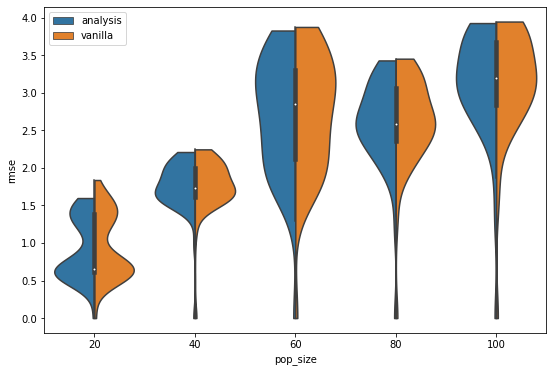

In [34]:
plt.figure(figsize=(9,6))
sns.violinplot(x='pop_size', y='rmse', hue='t', data=results,
               split=True, cut=0)
# sns.boxplot(x='pop_size', y='rmse', hue='t', data=results)
plt.legend(loc='upper left')
plt.show()